In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
%matplotlib inline
%load_ext cython

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

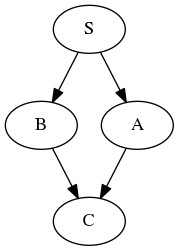

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [4]:
%%cython
import numpy as np
from libc.math cimport exp, sqrt

cdef double _sqrt_2_pi = sqrt(2 * np.pi)


cdef double _norm_pdf(double x):
    return exp(- x * x / 2.0) / _sqrt_2_pi


def cpdf(double[:] x, double[:] y, double delta_t, double sigma):
    '''
    Conditional probability density function (PDF) 
    for x evaluated at y + delta_t scaled by sigma that is
    p(Y=y|X=x) = sum_y(exp(-(z/sigma)^2) / (sqrt(2pi)*sigma)), 
    z = x - y - delta_t.
    '''
    cdef int i, j, M, N
    cdef double z, tmp
    cdef double[:] pdf
    M, N = len(x), len(y)
    pdf = np.zeros(M)
    for i in range(M):
        for j in range(N):
            z = x[i] - y[j] - delta_t
            tmp = _norm_pdf(z / sigma) / sigma
            pdf[i] = pdf[i] + tmp / N
    return pdf

In [5]:
def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count

In [6]:
def fit_latency(pre, post, binsize=.1, limit=[-20, 0], init=[0.5, 0.5], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.norm.pdf(x, p[0], p[1])
    error  = lambda p, x, y: (y - normpdf(p, x))
    (delta_t, sigma), _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf((delta_t, sigma), b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.2f} $\sigma$ {:.2f}'.format(delta_t, sigma))
        plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return delta_t, sigma

In [8]:
results = defaultdict(list)
amps = np.arange(0, 3.1, .1)
for a in amps:
    data = simulate(par, stim_N=10000, J_AC=a, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
    t_stop = data['status']['time']
    A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    stim_times = data['epoch']['times']
    
    delta_t_A, sigma_A = fit_latency(A_spikes, stim_times)
    pdf_A = cpdf(stim_times, A_spikes, delta_t_A, sigma_A)
    
    delta_t_B, sigma_B = fit_latency(B_spikes, stim_times)
    pdf_B = cpdf(stim_times, B_spikes, delta_t_B, sigma_B) 
    
    delta_t_C, sigma_C = fit_latency(C_spikes, stim_times)
    pdf_C = cpdf(stim_times, C_spikes, delta_t_C, sigma_C) 
    
    beta_AC = np.cov(pdf_C, pdf_A)[0,1] / np.var(pdf_C)
    beta_BC = np.cov(pdf_C, pdf_B)[0,1] / np.var(pdf_C)
    
    time_shift = 10
    delta_t_Ar, sigma_Ar = fit_latency(A_spikes, stim_times)
    pdf_Ar = cpdf(stim_times - time_shift, A_spikes, delta_t_Ar, sigma_Ar) 
    
    delta_t_Br, sigma_Br = fit_latency(B_spikes, stim_times)
    pdf_Br = cpdf(stim_times - time_shift, B_spikes, delta_t_Br, sigma_Br) 
    
    delta_t_Cr, sigma_Cr = fit_latency(C_spikes, stim_times)
    pdf_Cr = cpdf(stim_times - time_shift, C_spikes, delta_t_Cr, sigma_Cr) 
    
    beta_ACr = np.cov(pdf_Cr, pdf_Ar)[0,1] / np.var(pdf_Cr)
    beta_BCr = np.cov(pdf_Cr, pdf_Br)[0,1] / np.var(pdf_Cr)
    
    beta_AC_corrected = beta_AC - beta_ACr
    beta_BC_corrected = beta_BC - beta_BCr
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)    
    results['beta_ACr'].append(beta_ACr)    
    results['beta_BCr'].append(beta_BCr)    
    results['beta_ACc'].append(beta_AC_corrected)    
    results['beta_BCc'].append(beta_BC_corrected)
    results['rate_A'].append(len(A_spikes) / data['status']['time'] * 1000)
    results['rate_B'].append(len(B_spikes) / data['status']['time'] * 1000)
    results['rate_C'].append(len(C_spikes) / data['status']['time'] * 1000)

simulating  427015.0
stimulating  10000
simulating  424988.0
stimulating  10000
connecting  J_AC 0.1
simulating  424556.0
stimulating  10000
connecting  J_AC 0.2
simulating  425349.0
stimulating  10000
connecting  J_AC 0.30000000000000004
simulating  426573.0
stimulating  10000
connecting  J_AC 0.4
simulating  426504.0
stimulating  10000
connecting  J_AC 0.5
simulating  425581.0
stimulating  10000
connecting  J_AC 0.6000000000000001
simulating  426462.0
stimulating  10000
connecting  J_AC 0.7000000000000001
simulating  423505.0
stimulating  10000
connecting  J_AC 0.8
simulating  425517.0
stimulating  10000
connecting  J_AC 0.9
simulating  426081.0
stimulating  10000
connecting  J_AC 1.0
simulating  424378.0
stimulating  10000
connecting  J_AC 1.1
simulating  425654.0
stimulating  10000
connecting  J_AC 1.2000000000000002
simulating  425610.0
stimulating  10000
connecting  J_AC 1.3
simulating  424349.0
stimulating  10000
connecting  J_AC 1.4000000000000001
simulating  426058.0
stimulati

In [9]:
results['rate_C'] = np.array(results['rate_C'])

Text(0.5,1,'BC')

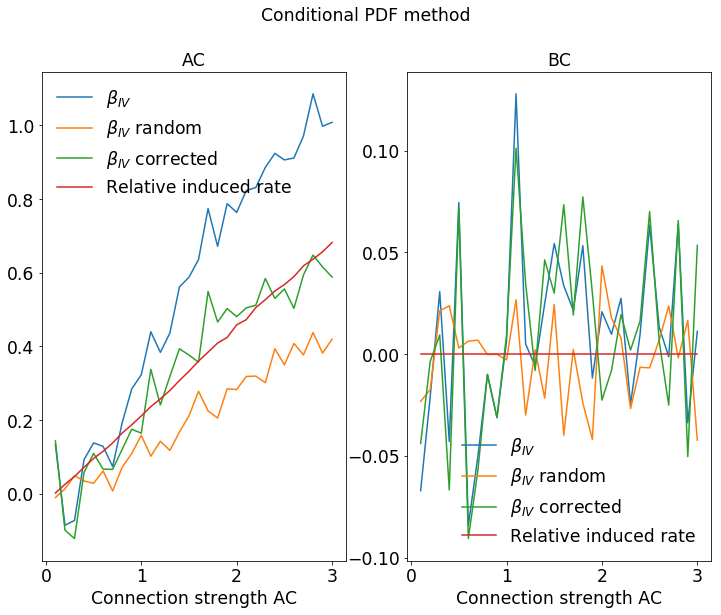

In [42]:
fig, (axa, axb) = plt.subplots(1,2)

plt.suptitle('Conditional PDF method', fontsize='xx-large')

axa.plot(amps[1:], results['beta_AC'][1:], label=r'$\beta_{IV}$')
axa.plot(amps[1:], results['beta_ACr'][1:], label=r'$\beta_{IV}$ random')
axa.plot(amps[1:], results['beta_ACc'][1:], label=r'$\beta_{IV}$ corrected')
axa.plot(amps[1:], results['rate_C'][1:] / results['rate_C'][0] - 1, label='Relative induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('Connection strength AC')
axa.set_title('AC')

axb.plot(amps[1:], results['beta_BC'][1:], label=r'$\beta_{IV}$')
axb.plot(amps[1:], results['beta_BCr'][1:], label=r'$\beta_{IV}$ random')
axb.plot(amps[1:], results['beta_BCc'][1:], label=r'$\beta_{IV}$ corrected')
axb.plot(amps[1:], np.zeros_like(amps[1:]), label='Relative induced rate')
axb.legend(frameon=False, loc=4)
axb.set_xlabel('Connection strength AC')
axb.set_title('BC')

In [46]:
results['rate_C'][0], results['rate_C'][amps==2], results['rate_C'][amps==2] - results['rate_C'][0]

(15.438654006018101, array([22.51980234]), array([7.08114833]))